# Predicting Linkedin Summary Topic Using LDA

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import bigfloat
bigfloat.exp(5000,bigfloat.precision(100))

BigFloat.exact('2.9676283840236670689662968052896e+2171', precision=100)

In [2]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [3]:
dataLinkedin = pd.read_csv('Datasets/datascientist.csv', error_bad_lines=False);

#Remove the first column
del dataLinkedin['Unnamed: 0'];

# We only need the summary text column from the data
linkedinSummary = dataLinkedin[['summary']];

In [4]:
#Remove NaNs
linkedinSummary.dropna(how='any', inplace=True)
linkedinSummary = linkedinSummary.astype('str');

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
#Remove unknown characters

import string
linkedinSummary = linkedinSummary.replace(r'\n',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'►',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'✔',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\t',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\-',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\'',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\"',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\/',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\:',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\•',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\...',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\... ',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\!',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\,',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\.',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\(',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\)',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\|',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\+',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\@',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\_',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\;',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\>',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\<',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'I',' ', regex=True)

In [6]:
linkedinSummarytwo = linkedinSummary.summary.values.tolist()
print(linkedinSummarytwo)

['Ambitious  driven  intelligent  steely  efficient  resourceful  critical  savvy  unrelenting Thinker  doer         realist  idealist  willing  able  can do  will do   ', 'Proactive  self motivated  and results driven data scientist who thrives in intellectually challenging positions xcels at establishing positive working relationships with stakeholders and leading technical teams from business concept through deployment of analytical solution ecognized for thought leadership and superior problem solving skills on projects that require creative  interdisciplinary solutions    ', '  have been learning and working in analytics since 2012 here are many reasons why   love this field he main reason is that   like to work on problems that are interesting and not trivial  do not have a specific list of languages and software that must fit with me  just enjoy the opportunity of working on complex data problems and trying to find a solution for them re is a list of data science topics and soft

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

linkedinSum = list(sent_to_words(linkedinSummarytwo))
print(linkedinSum)

[['ambitious', 'driven', 'intelligent', 'steely', 'efficient', 'resourceful', 'critical', 'savvy', 'unrelenting', 'thinker', 'doer', 'realist', 'idealist', 'willing', 'able', 'can', 'do', 'will', 'do'], ['proactive', 'self', 'motivated', 'and', 'results', 'driven', 'data', 'scientist', 'who', 'thrives', 'in', 'intellectually', 'challenging', 'positions', 'xcels', 'at', 'establishing', 'positive', 'working', 'relationships', 'with', 'stakeholders', 'and', 'leading', 'technical', 'teams', 'from', 'business', 'concept', 'through', 'deployment', 'of', 'analytical', 'solution', 'ecognized', 'for', 'thought', 'leadership', 'and', 'superior', 'problem', 'solving', 'skills', 'on', 'projects', 'that', 'require', 'creative', 'solutions'], ['have', 'been', 'learning', 'and', 'working', 'in', 'analytics', 'since', 'here', 'are', 'many', 'reasons', 'why', 'love', 'this', 'field', 'he', 'main', 'reason', 'is', 'that', 'like', 'to', 'work', 'on', 'problems', 'that', 'are', 'interesting', 'and', 'not'

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(linkedinSum, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[linkedinSum], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[linkedinSum[0]]])

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['ambitious', 'driven', 'intelligent', 'steely', 'efficient', 'resourceful', 'critical', 'savvy', 'unrelenting', 'thinker', 'doer', 'realist', 'idealist', 'willing', 'able', 'can', 'do', 'will', 'do']


In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(linkedinSum)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['ambitious', 'drive', 'intelligent', 'steely', 'efficient', 'resourceful', 'critical', 'savvy', 'unrelenting', 'thinker', 'doer', 'realist', 'idealist', 'willing', 'able']]


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_words_nostops

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (1964, 1)]]


In [12]:
id2word[15]

'analytical'

In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('able', 1),
  ('ambitious', 1),
  ('critical', 1),
  ('doer', 1),
  ('efficient', 1),
  ('idealist', 1),
  ('intelligent', 1),
  ('realist', 1),
  ('resourceful', 1),
  ('savvy', 1),
  ('steely', 1),
  ('thinker', 1),
  ('unrelenting', 1),
  ('willing', 1),
  ('driven', 1)]]

In [20]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [21]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.017*"swati" + 0.014*"electrical" + 0.013*"paced" + 0.013*"member" + 0.012*"fun" + 0.011*"fast" + 0.011*"time" + 0.010*"sense" + 0.010*"joy" + 0.008*"ethic"'), (1, '0.018*"unique" + 0.014*"role" + 0.014*"finding" + 0.010*"readily" + 0.010*"ssrs" + 0.009*"php" + 0.008*"hearstlab" + 0.008*"ssas" + 0.008*"ackground" + 0.007*"hana"'), (2, '0.038*"data" + 0.036*"sql" + 0.030*"python" + 0.027*"analysis" + 0.020*"experience" + 0.017*"tableau" + 0.017*"sas" + 0.016*"spark" + 0.016*"regression" + 0.014*"hadoop"'), (3, '0.024*"program" + 0.014*"global" + 0.013*"skilled" + 0.010*"group" + 0.010*"strategic" + 0.009*"side" + 0.008*"advertising" + 0.008*"director" + 0.007*"communicating" + 0.007*"one"'), (4, '0.012*"worth" + 0.010*"anomaly" + 0.009*"go" + 0.008*"nothing" + 0.006*"also" + 0.006*"molecular" + 0.006*"employ" + 0.006*"creativity" + 0.006*"startup" + 0.005*"basho"'), (5, '0.014*"challenging" + 0.012*"page" + 0.009*"monitoring" + 0.008*"capable" + 0.008*"administration" + 0.008*"ad

In [22]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.117159639489254

Coherence Score:  0.4353928411334424


In [23]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
8      52.903244        1       1  0.317056 -0.211129
2      23.565763        1       2  0.287727  0.179379
9       5.946580        1       3  0.049339  0.113249
6       4.243327        1       4 -0.047596  0.028887
3       2.895461        1       5 -0.107987 -0.032535
4       2.441697        1       6 -0.102727  0.002465
7       2.192155        1       7 -0.099860 -0.040397
5       2.124285        1       8 -0.096703 -0.031646
0       2.009342        1       9 -0.094299 -0.010126
1       1.678147        1      10 -0.104951  0.001853, topic_info=     Category         Freq            Term        Total  loglift  logprob
term                                                                     
20    Default  1203.000000            data  1203.000000  30.0000  30.0000
276   Default   175.000000             sql   175.000000  29.0000  29.0000
194   Default   264.000000        analysis   264.000000  28.0000  28.0000
268   Default   189.000000          python   189.000000  27.0000  27.0000
90    Default   286.000000         science   286.000000  26.0000  26.0000
254   Default   401.000000        learning   401.000000  25.0000  25.0000
290   Default    56.000000        building    56.000000  24.0000  24.0000
178   Default    84.000000            time    84.000000  23.0000  23.0000
547   Default    36.000000       expertise    36.000000  22.0000  22.0000
280   Default    79.000000         tableau    79.000000  21.0000  21.0000
507   Default    79.000000             sas    79.000000  20.0000  20.0000
152   Default    54.000000          neural    54.000000  19.0000  19.0000
35    Default   212.000000       scientist   212.000000  18.0000  18.0000
275   Default    82.000000           spark    82.000000  17.0000  17.0000
319   Default    52.000000            also    52.000000  16.0000  16.0000
189   Default   281.000000      experience   281.000000  15.0000  15.0000
119   Default    86.000000            deep    86.000000  14.0000  14.0000
88    Default    80.000000      regression    80.000000  13.0000  13.0000
2103  Default    27.000000             end    27.000000  12.0000  12.0000
364   Default    50.000000         network    50.000000  11.0000  11.0000
50    Default    34.000000  classification    34.000000  10.0000  10.0000
241   Default    69.000000          hadoop    69.000000   9.0000   9.0000
949   Default    40.000000             web    40.000000   8.0000   8.0000
639   Default    26.000000              ms    26.000000   7.0000   7.0000
68    Default    56.000000           learn    56.000000   6.0000   6.0000
73    Default    28.000000            love    28.000000   5.0000   5.0000
557   Default    28.000000           https    28.000000   4.0000   4.0000
427   Default    44.000000          master    44.000000   3.0000   3.0000
67    Default    35.000000        language    35.000000   2.0000   2.0000
774   Default    32.000000      interested    32.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
3873  Topic10     2.796447       hearstlab     3.391670   3.8945  -4.7823
781   Topic10     2.743022            ssas     3.338534   3.8910  -4.8016
2397  Topic10     2.678301       ackground     3.273438   3.8868  -4.8255
3038  Topic10     2.388915            hana     2.984755   3.8648  -4.9398
940   Topic10     2.261055           roven     2.856416   3.8537  -4.9948
1050  Topic10     2.182980         subject     2.778185   3.8464  -5.0300
3529  Topic10     1.915750        apparent     2.510898   3.8169  -5.1605
3530  Topic10     1.915750            host     2.510898   3.8169  -5.1605
3532  Topic10     1.915750       switching     2.510898   3.8169  -5.1605
293   Topic10     1.915750            draw     2.510898   3.8169  -5.1605
3458  Topic10     1.915691          inform     2.510918   3.8169  -5.1606
2992  Topic10     1.784291     transaction     2.3794

In [24]:
mallet_path = '/Users/miguelbriones/Desktop/Insight/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [25]:
# Show Topics
print(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0, [('learning', 0.23478729133010232), ('machine', 0.1674744211093161), ('deep', 0.04738826063543349), ('algorithms', 0.031771674744211095), ('processing', 0.027463651050080775), ('solve', 0.02207862143241788), ('nlp', 0.02207862143241788), ('language', 0.01992460958535272), ('mining', 0.01830910070005385), ('natural', 0.01669359181475498)]), (1, [('data', 0.24161073825503357), ('scientist', 0.12416107382550336), ('modeling', 0.028523489932885907), ('passionate', 0.026845637583892617), ('marketing', 0.02237136465324385), ('real', 0.020134228187919462), ('product', 0.018456375838926176), ('actionable', 0.01621923937360179), ('google', 0.012863534675615212), ('advanced', 0.012304250559284116)]), (2, [('science', 0.06666666666666667), ('university', 0.045730027548209366), ('professional', 0.03360881542699724), ('technology', 0.029201101928374655), ('engineering', 0.02809917355371901), ('industry', 0.024242424242424242), ('working', 0.023691460055096418), ('master', 0.01928374655647383),

In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

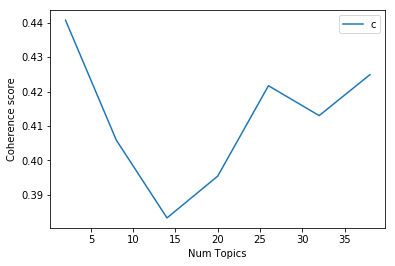

In [28]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [29]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4407
Num Topics = 8  has Coherence Value of 0.4059
Num Topics = 14  has Coherence Value of 0.3833
Num Topics = 20  has Coherence Value of 0.3955
Num Topics = 26  has Coherence Value of 0.4217
Num Topics = 32  has Coherence Value of 0.413
Num Topics = 38  has Coherence Value of 0.4249


In [30]:
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.318*"data" + 0.027*"software" + 0.027*"big" + 0.026*"professional" + '
  '0.019*"experienced" + 0.016*"driven" + 0.016*"development" + '
  '0.015*"ability" + 0.014*"product" + 0.012*"full"'),
 (1,
  '0.088*"business" + 0.040*"sql" + 0.035*"sas" + 0.030*"mining" + '
  '0.029*"management" + 0.024*"python" + 0.023*"design" + 0.022*"tableau" + '
  '0.022*"building" + 0.020*"project"'),
 (2,
  '0.049*"research" + 0.043*"work" + 0.035*"university" + 0.033*"engineering" '
  '+ 0.031*"computer" + 0.024*"technology" + 0.019*"industry" + 0.018*"team" + '
  '0.017*"world" + 0.014*"graduate"'),
 (3,
  '0.052*"working" + 0.047*"scientist" + 0.027*"background" + '
  '0.025*"passionate" + 0.024*"complex" + 0.019*"applied" + 0.018*"solve" + '
  '0.018*"passion" + 0.016*"love" + 0.014*"https"'),
 (4,
  '0.201*"learning" + 0.148*"machine" + 0.041*"deep" + 0.032*"algorithms" + '
  '0.024*"processing" + 0.019*"nlp" + 0.019*"big" + 0.018*"language" + '
  '0.018*"text" + 0.016*"mining"'),
 (5,
  '

In [34]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=linkedinSummarytwo):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=linkedinSummarytwo)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.2509,"working, scientist, background, passionate, co...",Ambitious driven intelligent steely effici...
1,1,1.0,0.1609,"business, sql, sas, mining, management, python...",Proactive self motivated and results driven ...
2,2,6.0,0.1664,"data, science, scientist, technical, master, r...",have been learning and working in analytics ...
3,3,2.0,0.2106,"research, work, university, engineering, compu...",Data Science as evident involves scientific ...
4,4,6.0,0.1530,"data, science, scientist, technical, master, r...",Data scientist with academic background in gen...
5,5,3.0,0.1790,"working, scientist, background, passionate, co...",am an engineer focused on solving real world...
6,6,7.0,0.3088,"python, analysis, regression, spark, sql, hado...",Data scientist with a strong math background a...
7,7,1.0,0.1776,"business, sql, sas, mining, management, python...",am a Data Strategist who has experience iden...
8,8,2.0,0.2980,"research, work, university, engineering, compu...",am a very energetic goal driven person pass...
9,9,2.0,0.1553,"research, work, university, engineering, compu...",Finished a four year in data science and am lo...


In [35]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3974,"data, software, big, professional, experienced...",Professional qualified Data Scientist Data A...
1,1.0,0.6228,"business, sql, sas, mining, management, python...",Strong analytical background with special exp...
2,2.0,0.6241,"research, work, university, engineering, compu...",am currently a data scientist at Bloomberg ...
3,3.0,0.3201,"working, scientist, background, passionate, co...",⚠️⚠️ ’ve hit the limit of 30 000 connections ...
4,4.0,0.3187,"learning, machine, deep, algorithms, processin...",neo generalist currently focused on natural la...


In [36]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,3.0,"working, scientist, background, passionate, co...",40.0,0.0891
1,1.0,"business, sql, sas, mining, management, python...",40.0,0.0891
2,6.0,"data, science, scientist, technical, master, r...",72.0,0.1604
3,2.0,"research, work, university, engineering, compu...",66.0,0.1470
4,6.0,"data, science, scientist, technical, master, r...",60.0,0.1336
5,3.0,"working, scientist, background, passionate, co...",51.0,0.1136
6,7.0,"python, analysis, regression, spark, sql, hado...",57.0,0.1269
7,1.0,"business, sql, sas, mining, management, python...",63.0,0.1403
8,2.0,"research, work, university, engineering, compu...",NaN,NaN
9,2.0,"research, work, university, engineering, compu...",NaN,NaN
